## Load packages

In [1]:
import numpy as np
import pandas as pd
import math
from keras import layers
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
# set number of cores to 8
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=8, 
                                                   inter_op_parallelism_threads=8)))

## Load dataset

In [3]:
# load processed genetic data from 1000 Genomes
chr1 = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')

# flag for continental or population-level ancestry
continental=True

# create dict mapping from sampleid to superpopulation
sample_info = pd.read_csv('/home/jsokol/Data/igsr_samples.tsv', delimiter="\t").set_index('Sample name')
sample_to_superpopulation = sample_info['{}opulation code'.format('Superp' if continental else 'P')].dropna().to_dict()
# propagate samples removed above
keep = set()
for i,x in enumerate(np.nditer(chr1['S'])):
    sample_id = chr1['S'][i].decode().split('_')[0] # remove strand label
    if sample_id in sample_to_superpopulation:
        keep.add(i)
                
# define these for use, print input shape
V = chr1['V']
X = chr1['G'][np.array(list(keep)),:,:]
X.shape

(5008, 57876, 4)

In [4]:
# define number of output classes
classes = {val:key for key,val in enumerate(set(sample_to_superpopulation.values()))}
classes

{'AMR': 0, 'EUR': 1, 'EAS': 2, 'SAS': 3, 'AFR': 4}

In [5]:
# one hot encode labels
Y = np.zeros((X.shape[0], len(classes)))
for i,ix in enumerate(list(keep)):
    sample_id = chr1['S'][ix].decode().split('_')[0]
    Y[i, classes[sample_to_superpopulation[sample_id]]] = 1

# show some random samples
Y[np.array([1,353,2043]), :] 

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [6]:
[X.shape, Y.shape]

[(5008, 57876, 4), (5008, 5)]

In [7]:
# randomly shuffle the order of the data
randomize = np.random.choice(X.shape[0], X.shape[0], replace=False)
X = X[randomize,:]
Y = Y[randomize,:]

In [8]:
# split data into training and test sets
ntrain=4000
X_train = X[:ntrain,:,:]
X_test = X[ntrain:,:,:]
Y_train = Y[:ntrain,:]
Y_test = Y[ntrain:,:]
print(X_train.shape, Y_train.shape)

(4000, 57876, 4) (4000, 5)


## Build model

In [9]:
def cnn_cat(shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=shape)

    # First convolutional block
    s=512
    X = Conv1D(filters=64, kernel_size=s ,strides=s//2, padding = 'valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #  Second convolutional block
    X = Conv1D(32, 64, strides = 4, padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('tanh')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(64, activation='tanh')(X)
    X = Dense(Y.shape[1], activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='cnn_cat')
    
    return model

## Create and compile the model 

In [10]:
# create model
model = cnn_cat(X.shape[1:])
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 57876, 4)          0         
_________________________________________________________________
conv0 (Conv1D)               (None, 225, 64)           131136    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 225, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 225, 64)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 57, 32)            131104    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 57, 32)            128       
_________________________________________________________________
activation_2 (Activation)    (None, 57, 32)            0         
__________

## Train model

In [11]:
history=model.fit(X_train[:,:,:], Y_train[:,:], epochs = 4 if continental else 16, batch_size = 128,
                  validation_data=(X_test[:,:,:], Y_test))

Train on 4000 samples, validate on 1008 samples
Epoch 1/4
4000/4000 [==============================] - 16s 4ms/step - loss: 0.8271 - acc: 0.7848 - val_loss: 0.2304 - val_acc: 0.9702
Epoch 2/4
4000/4000 [==============================] - 16s 4ms/step - loss: 0.1064 - acc: 0.9832 - val_loss: 0.0764 - val_acc: 0.9881
Epoch 3/4
4000/4000 [==============================] - 16s 4ms/step - loss: 0.0368 - acc: 0.9963 - val_loss: 0.0578 - val_acc: 0.9881
Epoch 4/4
4000/4000 [==============================] - 16s 4ms/step - loss: 0.0180 - acc: 0.9988 - val_loss: 0.0486 - val_acc: 0.9921


## Evaluate model

Text(0.5, 0, 'Epoch')

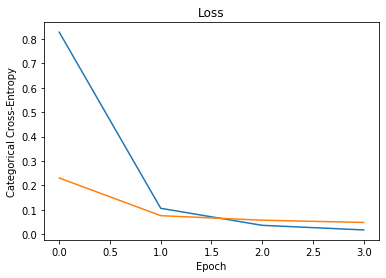

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

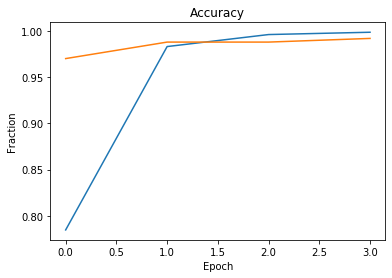

In [13]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy')
plt.ylabel('Fraction')
plt.xlabel('Epoch')

In [14]:
test_Y_hat=model.predict(X_test[:,:,:])
result=confusion_matrix(np.argmax(test_Y_hat, axis=-1).flatten(), 
                        np.argmax(Y_test, axis=-1).flatten())
x=pd.DataFrame(result, index=[k for k,v in sorted(classes.items(), key=lambda x:x[1]) if Y_test[:,v].any()], 
                     columns=[k for k,v in sorted(classes.items(), key=lambda x:x[1]) if Y_test[:,v].any()])

In [15]:
labels={v:k for k,v in classes.items()}
pd.Series(np.argmax(Y_test, axis=-1).flatten()).apply(labels.get).value_counts()

AFR    245
EUR    229
EAS    211
SAS    191
AMR    132
dtype: int64

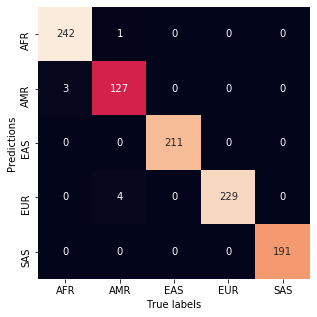

In [16]:
# misclassification table as heatmap, with borders for continents
fig, ax=plt.subplots(figsize=(6 if continental else 12, 5 if continental else 11))

# order by continent
if not continental:
    cont_order=['GWD','ESN','YRI','LWK','MSL','ACB', # africa
                'PUR','CLM','PEL','ASW','MXL', # americas
                'FIN','GBR','CEU','IBS','TSI', # europe
                'PJL','GIH','ITU','STU','BEB', # south asia
                'CDX','KHV','CHS','CHB','JPT'] # east asia
    for i in np.cumsum([6,5,5,5,5]):
        plt.plot((i,i),(0,29),'r-')
        plt.plot((0,29),(i,i),'r-')
else:
    cont_order=['AFR','AMR','EAS','EUR','SAS']

sns.heatmap(x.loc[cont_order, cont_order], annot=True, square=True, fmt="d", ax=ax, cbar=False);
plt.xlabel('True labels'); plt.ylabel('Predictions');